In [10]:
from skopt.space import Real, Integer, Categorical
import numpy as np
import torch
import torch.nn as nn
import torchbnn as bnn  # torchbnn library for BNN layers
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from tqdm import tqdm

In [11]:
class BayesianNNWithUncertainty(nn.Module):
    def __init__(self, input_dim, prior_mu, prior_sigma, layer1_units, layer2_units):
        super(BayesianNNWithUncertainty, self).__init__()
        
        # Epistemic layers (Bayesian)
        self.fc1 = bnn.BayesLinear(prior_mu, prior_sigma, in_features=input_dim, out_features=layer1_units)
        self.fc2 = bnn.BayesLinear(prior_mu, prior_sigma, in_features=layer1_units, out_features=layer2_units)
        self.fc3_mean = bnn.BayesLinear(prior_mu, prior_sigma, in_features=layer2_units, out_features=1)
        
        # Aleatoric log variance layer
        self.logvar_fc = nn.Linear(layer2_units, 1)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Shared feature extraction
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        
        # Predictive mean (logits for classification)
        mean = self.sigmoid(self.fc3_mean(x))
        
        # Predictive log variance for aleatoric uncertainty
        log_variance = self.logvar_fc(x)
        
        return mean, log_variance

In [12]:
def heteroscedastic_loss(y_pred_mean, y_pred_logvar, y_true):
    variance = torch.exp(y_pred_logvar)  # Convert log variance to variance
    loss = 0.5 * torch.log(variance) + (y_true - y_pred_mean) ** 2 / (2 * variance)
    return loss.mean()

In [13]:
def train_bayesian_nn_uncertainty(model, loader, optimizer):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        
        # Get mean and log variance predictions
        mean, log_var = model(X_batch)
        y_batch = y_batch.unsqueeze(1)  # Ensure y_batch shape matches output

        # Compute loss
        loss = heteroscedastic_loss(mean, log_var, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [29]:


def evaluate_bayesian_nn_with_uncertainty(model, loader, n_samples=50):
    model.eval()
    all_preds = []
    aleatoric_uncertainties = []
    epistemic_uncertainties = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            mean_preds = []
            logvar_preds = []
            for _ in range(n_samples):
                y_pred_mean, y_pred_logvar = model(X_batch)
                mean_preds.append(y_pred_mean.squeeze().cpu().numpy())
                logvar_preds.append(y_pred_logvar.squeeze().cpu().numpy())
            
            mean_preds = np.array(mean_preds)  # Shape: (n_samples, batch_size)
            logvar_preds = np.array(logvar_preds)  # Shape: (n_samples, batch_size)

            # Epistemic uncertainty: standard deviation of sampled means
            epistemic_uncertainty = mean_preds.std(axis=0)

            # Aleatoric uncertainty: average predicted variance
            aleatoric_uncertainty = np.exp(np.clip(logvar_preds, -10, 10)).mean(axis=0)

            # Combined uncertainty (optional)
            total_uncertainty = np.sqrt(epistemic_uncertainty**2 + aleatoric_uncertainty)

            # Handle batch size variability
            mean_prediction = mean_preds.mean(axis=0)
            if np.isscalar(mean_prediction):
                all_preds.append(mean_prediction)
                aleatoric_uncertainties.append(aleatoric_uncertainty)
                epistemic_uncertainties.append(epistemic_uncertainty)
            else:
                all_preds.extend(mean_prediction)
                aleatoric_uncertainties.extend(aleatoric_uncertainty)
                epistemic_uncertainties.extend(epistemic_uncertainty)

            all_labels.extend(y_batch.cpu().numpy())

    return (
        np.array(all_preds),
        np.array(aleatoric_uncertainties),
        np.array(epistemic_uncertainties),
        np.array(all_labels),
    )


In [15]:
def plot_reliability_diagram(y_preds, y_true, bins=10):
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_indices = np.digitize(y_preds, bin_edges, right=True) - 1

    accuracies = []
    confidences = []
    for i in range(bins):
        bin_mask = bin_indices == i
        if np.any(bin_mask):
            accuracies.append(y_true[bin_mask].mean())
            confidences.append(y_preds[bin_mask].mean())
        else:
            accuracies.append(0)
            confidences.append(0)

    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
    plt.plot(confidences, accuracies, marker="o", label="Model Calibration")
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.grid()
    plt.show()


def plot_uncertainty(preds, epistemic, aleatoric):
    total_uncertainty = np.sqrt(epistemic**2 + aleatoric)

    plt.figure(figsize=(10, 6))
    plt.scatter(preds, epistemic, alpha=0.5, label="Epistemic", edgecolor="k")
    plt.scatter(preds, aleatoric, alpha=0.5, label="Aleatoric", edgecolor="k")
    plt.scatter(preds, total_uncertainty, alpha=0.5, label="Total Uncertainty", edgecolor="k")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Uncertainty")
    plt.title("Uncertainty vs Prediction")
    plt.legend()
    plt.grid()
    plt.show()

In [22]:
# Running the model with proper validation and testing
def run_bayesian_nn_with_uncertainty(n, hyper_params, n_samples=50):
    # Load dataset
    X = np.load(f'Datasets/kryptonite-{n}-X.npy')
    y = np.load(f'Datasets/kryptonite-{n}-y.npy')

    # Split dataset into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% val, 20% test

    # Convert datasets to PyTorch tensors
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
    X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
    X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

    # Create data loaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=hyper_params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=hyper_params['batch_size'])
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

    # Define model
    input_dim = X_train.shape[1]
    model = BayesianNNWithUncertainty(
        input_dim=input_dim,
        prior_mu=hyper_params['prior_mu'],
        prior_sigma=hyper_params['prior_sigma'],
        layer1_units=hyper_params['layer1_units'],
        layer2_units=hyper_params['layer2_units'],
    )

    # Optimiser
    optimizer = optim.RAdam(model.parameters(), lr=hyper_params['learning_rate'])

    # Training loop
    for epoch in range(hyper_params['epochs']):
        train_loss = train_bayesian_nn_uncertainty(model, train_loader, optimizer)
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")

    # Validation performance and uncertainty visualisation
    print("\nEvaluating on validation set...")
    y_preds_val, aleatoric_uncertainty_val, epistemic_uncertainty_val, y_true_val = evaluate_bayesian_nn_with_uncertainty(
        model, val_loader, n_samples=n_samples
    )

    val_accuracy = accuracy_score((y_preds_val > 0.5).astype(int), y_true_val)
    print(f"Validation Accuracy for n={n}: {val_accuracy:.4f}")

    # Plot reliability and uncertainty for validation set
    plot_reliability_diagram(y_preds_val, y_true_val)
    plot_uncertainty(y_preds_val, epistemic_uncertainty_val, aleatoric_uncertainty_val)

    # Final test set evaluation
    print("\nEvaluating on test set...")
    y_preds_test, aleatoric_uncertainty_test, epistemic_uncertainty_test, y_true_test = evaluate_bayesian_nn_with_uncertainty(
        model, test_loader, n_samples=n_samples
    )

    test_accuracy = accuracy_score((y_preds_test > 0.5).astype(int), y_true_test)
    print(f"Test Accuracy for n={n}: {test_accuracy:.4f}")

    # Optionally plot uncertainty for the test set
    plot_uncertainty(y_preds_test, epistemic_uncertainty_test, aleatoric_uncertainty_test)

    return val_accuracy, test_accuracy


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Train Loss: -0.1378
Epoch 2, Train Loss: -0.1920
Epoch 3, Train Loss: -0.1953
Epoch 4, Train Loss: -0.2072
Epoch 5, Train Loss: -0.2491
Epoch 6, Train Loss: -0.3820
Epoch 7, Train Loss: -0.6376
Epoch 8, Train Loss: -0.8872
Epoch 9, Train Loss: -1.0013
Epoch 10, Train Loss: -1.0595
Epoch 11, Train Loss: -1.1021
Epoch 12, Train Loss: -1.1452
Epoch 13, Train Loss: -1.1558
Epoch 14, Train Loss: -1.1848
Epoch 15, Train Loss: -1.1910
Epoch 16, Train Loss: -1.2353
Epoch 17, Train Loss: -1.2279
Epoch 18, Train Loss: -1.2096
Epoch 19, Train Loss: -1.2625
Epoch 20, Train Loss: -1.1893
Epoch 21, Train Loss: -1.1882
Epoch 22, Train Loss: -1.2915
Epoch 23, Train Loss: -1.2925
Epoch 24, Train Loss: -1.3559
Epoch 25, Train Loss: -1.3397
Epoch 26, Train Loss: -1.2642
Epoch 27, Train Loss: -1.2815
Epoch 28, Train Loss: -1.3151
Epoch 29, Train Loss: -1.3940
Epoch 30, Train Loss: -1.2045
Epoch 31, Train Loss: -1.3944
Epoch 32, Train Loss: -1.2815
Epoch 33, Train Loss: -1.4068
Epoch 34, Train Los

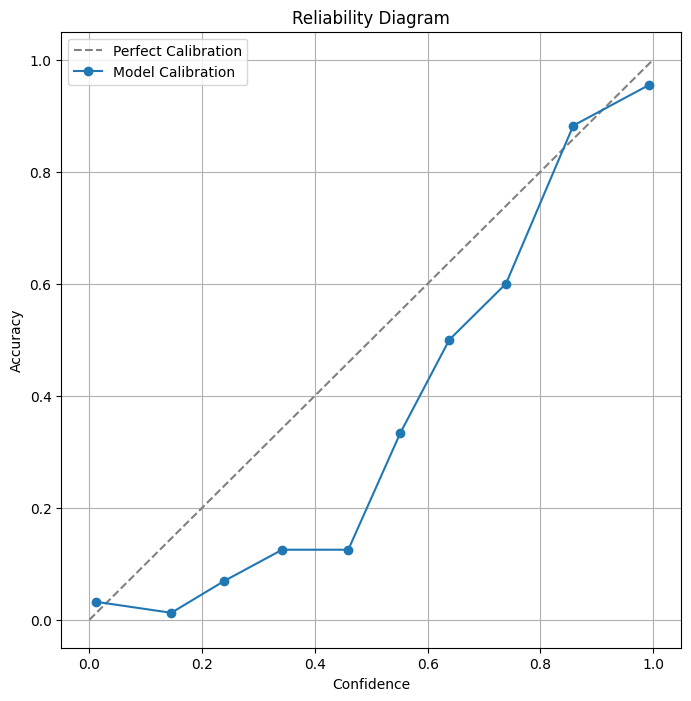

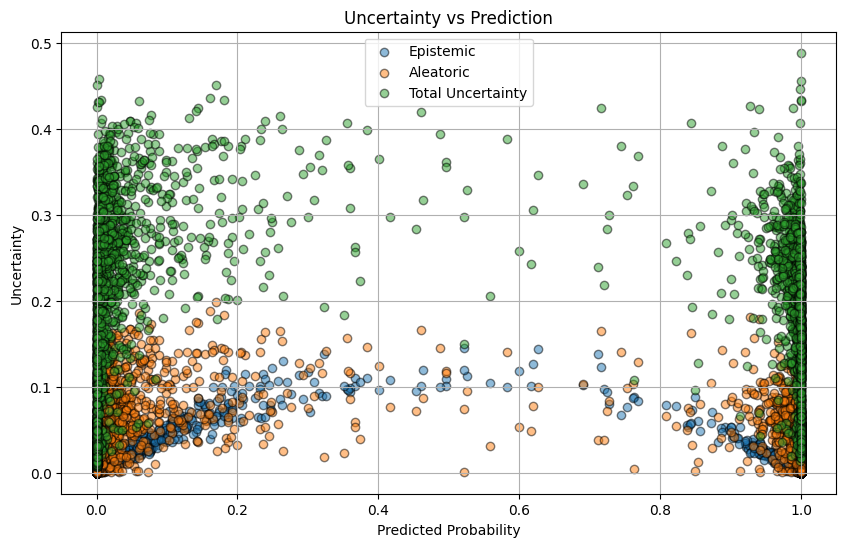


Evaluating on test set...
Test Accuracy for n=9: 0.9564


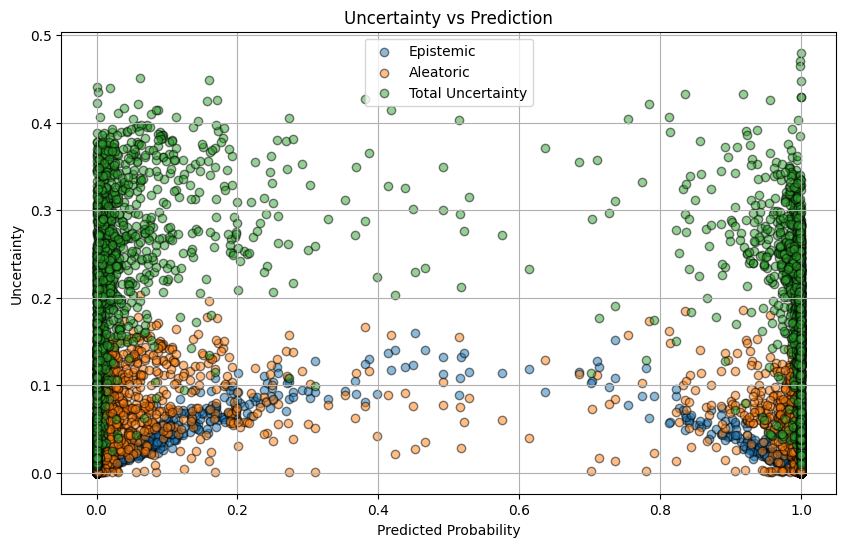

100%|██████████| 1/1 [00:51<00:00, 51.73s/it]

Accuracies across different n values: [(9, (0.9580555555555555, 0.9563888888888888))]


In [31]:
# Run for each n value and collect accuracies
results = []



hyper_params12 = {
    'optimizer': 'RAdam',
    'learning_rate': 0.0033045788103494866,
    'batch_size': 25,
    'layer1_units': 128,
    'layer2_units': 64,
    'prior_mu': 0.0,
    'prior_sigma': 0.5,
    'epochs': 50
}


hyper_params9 = {
    'optimizer': 'AdamW',
    'learning_rate': 0.0008723870504337456,
    'batch_size': 34,
    'layer1_units': 128,
    'layer2_units': 38,
    'prior_mu': 0.5703850157555145,
    'prior_sigma': 0.01,
    'epochs': 67
}


hyper_params15 = {
    'optimizer': 'RAdam',
    'learning_rate': 0.002125965027963112,
    'batch_size': 85,
    'layer1_units': 32,
    'layer2_units': 16,
    'prior_mu': 0.0,
    'prior_sigma': 0.5,
    'epochs': 200
}




hyper_params_dict = {
    9: hyper_params9,
    12: hyper_params12,
    15: hyper_params15,
}


possible_n_vals = [9]
for n in tqdm(possible_n_vals):
    hyper_params = hyper_params_dict[n]
    accuracy = run_bayesian_nn_with_uncertainty(n, hyper_params)
    results.append((n, accuracy))

print("Accuracies across different n values:", results)

# Threshold grid for each n value
thresh_grid = {
    '9': 0.95,  
    '12': 0.925,
    '15': 0.90,
    '18': 0.875,
    '24': 0.80,
    '30': 0.75,
    '45': 0.70
}


In [30]:
space = [
    Categorical(['Adam', 'AdamW', 'RAdam'], name='optimizer'),
    Real(1e-6, 1e-1, prior='log-uniform', name='learning_rate'),
    Integer(32, 128, name='batch_size'),
    Integer(32, 128, name='layer1_units'),
    Integer(16, 64, name='layer2_units'),
    Real(0.0, 1.0, name='prior_mu'),
    Real(0.01, 0.5, name='prior_sigma'),
    Integer(10, 200, name='epochs')
]



# Objective function to optimize using Gaussian Process
# Objective function to optimise using Gaussian Process
@use_named_args(space)
def objective_function(optimizer, learning_rate, batch_size, layer1_units, layer2_units, prior_mu, prior_sigma, epochs, n=9, n_samples=50):
    # Load the data
    X = np.load(f'Datasets/kryptonite-{n}-X.npy')
    y = np.load(f'Datasets/kryptonite-{n}-y.npy')

    # Split dataset into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% val, 20% test

    # Convert datasets to PyTorch tensors
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
    X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

    batch_size = int(max(16, batch_size))
    # Create data loaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

    # Define model
    input_dim = X_train.shape[1]
    model = BayesianNNWithUncertainty(
        input_dim=input_dim,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        layer1_units=layer1_units,
        layer2_units=layer2_units,
    )

    # Select optimizer dynamically
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizer == 'RAdam':
        optimizer = optim.RAdam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        train_loss = train_bayesian_nn_uncertainty(model, train_loader, optimizer)

    # Validation performance
    y_preds_val, aleatoric_uncertainty_val, epistemic_uncertainty_val, y_true_val = evaluate_bayesian_nn_with_uncertainty(
        model, val_loader, n_samples=n_samples
    )
    val_accuracy = accuracy_score((y_preds_val > 0.5).astype(int), y_true_val)

    return -val_accuracy  # Minimisation requires a negative score

# Run Bayesian Optimization
results = gp_minimize(objective_function, space, n_calls=50, random_state=42, verbose=True)

# Print the best hyperparameters found
print("Best hyperparameters found:")
for param, value in zip(space, results.x):
    print(f"{param.name}: {value}")


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 21.1279
Function value obtained: -0.5017
Current minimum: -0.5017
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 79.1753
Function value obtained: -0.4989
Current minimum: -0.5017
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 34.0782
Function value obtained: -0.5103
Current minimum: -0.5103
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 33.3451
Function value obtained: -0.5011
Current minimum: -0.5103
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 32.7621
Function value obtained: -0.5000
Current minimum: -0.5103
Iteration No: 6 star